# Simple network of two hidden dense layers

## Stochastic gradient descent / online learning

Retropropagation 
- en utilisant un eboucle explicite
- en mettant à jour après chaque observation (online learning / stochastic gradient descent)

Architecture

    input (layer0) : 2 variables
    layer 1: 3 neurons (sigmoid)
    layer 2: 5 neurons (sigmoid)
    layer 3 (output) : single neuron (sigmoid)

    L0  L1   L2   L3
    
    x1    /  o 
      \ o    o  \
        o    o    o ->
      / o    o  /
    x2    \  o

$W_1 \in M_{3,2}$

$W_2 \in M_{5,3}$

$W_3 \in M_{1, 5}$

In [23]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt

### Dataset

In [24]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=20, noise=0.05, random_state=12345) # not too hard
X.shape, y.shape

((20, 2), (20,))

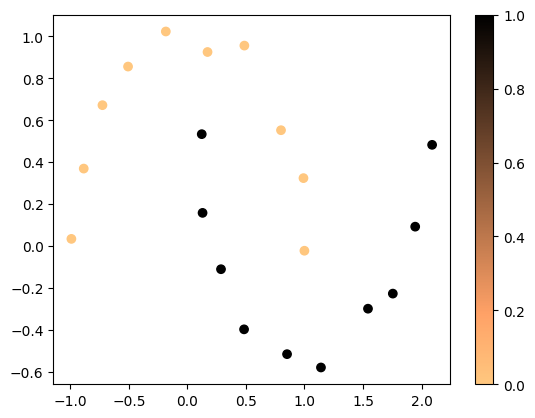

In [25]:
plt.scatter(X[:,0], X[:, 1], c=y, cmap='copper_r')
plt.colorbar()
plt.show()

## Network construction / initialisation


In [26]:
# random init for weights
np.random.seed(124)
# Weights matrix: one line per neuron, one column per neuron in the previous layer
W1 = randn(3, 2)   
# Column vector of bias (compatible with forward pass formula)
b1 = randn(3, 1) 

W2 = randn(5, 3)
b2 = randn(5, 1)

W3 = randn(1, 5)
b3 = randn(1, 1)  # not a scalar (!) but 1x1 matrix


In [27]:
W2

array([[-0.71988132, -0.96488339,  0.25358279],
       [ 0.3080074 , -0.071606  , -1.13548051],
       [-0.1022454 ,  0.80818623,  0.23199239],
       [-1.40035848,  0.71590778, -2.12456763],
       [ 1.24141343,  0.23631196, -1.08889182]])

In [28]:
def sigma(x):
    return 1 / (1 + np.exp(-x))

def sigprim(x):
    return sigma(x) * (1 - sigma(x))

## Forward pass for *one* training instance

In [29]:
# We will process just the first training example
# To use the same notation as on paper, we put it in a 2D column vector
# Activations of the input layer:
ind0 = 0  # on choisit les poids d'indice 0
a0 = X[ind0:ind0+1, :].T # activation dans la couche d'entrée: les coeffs de la ligne 0 du dataset
a0.shape

(2, 1)

In [30]:
z1 = W1 @ a0 + b1 # selon la formule mathématiques du cours
# shape (3, 2) * (2, 1) -> (3, 1)
a1 = sigma(z1)
a1.shape

(3, 1)

In [31]:
z2 = W2 @ a1 + b2
a2 = sigma(z2)
# shape (5, 3) * (3, 1) -> (5, 1)
z2.shape # matrice colonne, 1 coef par neurone dans la couche 2

(5, 1)

In [32]:
z3 = W3 @ a2 + b3
a3 = sigma(z3)
# shape (1, 5) * (5, 1) -> (1, 1)
a3.shape, a3 

((1, 1), array([[0.17909398]]))

In [33]:
# Valeur numérique (deux indices)

a3[0, 0]

0.17909397509745908


## Backpropagation

Error (shift, correction?) in the output layer [**BP1**]

$\displaystyle \delta_j^L = (a^L - y) \odot \sigma'(z_j^L)$ 

(only one neuron here, so $j$ index might be omitted)

In [34]:
delta3 = (a3 - y[ind0]) * sigprim(z3)
print(delta3.shape) # un seul neurone dans la dernière couche

(1, 1)


Backpropagate the error [**BP2**]

$\displaystyle \delta^l = ((W^{l+1})^T)\delta^{l+1} \odot \sigma'(z^{l})$

In [35]:
# l = 2 pour calculer delta2

delta2 = (W3.T @ delta3) * sigprim(z2)
delta2, delta2.shape

(array([[ 0.03233452],
        [-0.01356514],
        [ 0.01342836],
        [-0.00326986],
        [ 0.05845582]]),
 (5, 1))

In [36]:
# l = 1 pour delta1

delta1 = (W2.T @ delta2) * sigprim(z1)
delta1, delta1.shape # il y a 3 neurones dans la couche 1

(array([[ 0.01073452],
        [-0.00197333],
        [-0.00703027]]),
 (3, 1))

#### The gradient for the biases [**BP3**]

$\displaystyle \frac{\partial C}{\partial b_j^l} = \delta_j^l$

In [37]:
nabla_b1 = delta1 # première couche
nabla_b2 = delta2 # deuxième couche
nabla_b3 = delta3 # troisième couche (1 neurone)

In [38]:
nabla_b1, nabla_b2, nabla_b3

(array([[ 0.01073452],
        [-0.00197333],
        [-0.00703027]]),
 array([[ 0.03233452],
        [-0.01356514],
        [ 0.01342836],
        [-0.00326986],
        [ 0.05845582]]),
 array([[-0.12068905]]))

#### The gradient for weights **[BP4]**, mathematical formula

$\displaystyle \frac{\partial C}{\partial w_{jk}^l} = a_k^{l-1}\delta_j^l = \delta_j^l a_k^{l-1} $


### Remarque

- Si on formate $delta^l$ en colonne et $a^(l-1)$ en ligne, le produit matriciel
- $delta^l a^(l-1)$ donnera "d'un seul coup" la matrice du gradient $ \frac{\partial C}{\partial w_{jk}^l} = a_k^{l-1}\delta_j^l = \delta_j^l a_k^{l-1} $

Mais dans un premier temps, on va faire ce même calcul coef par coef (dans une boucle imbriquée)

In [39]:
nabla_W3 = np.zeros(W3.shape)

for j in range(W3.shape[0]): # Pour chaque ligne
    for k in range(W3.shape[1]): # Pour chaque colonne
        nabla_W3[j, k] = a2[k, 0] * delta3[j, 0]

nabla_W3

array([[-0.06449463, -0.04275555, -0.06734968, -0.01992108, -0.07965439]])

In [40]:
nabla_W2 = np.zeros(W2.shape)

for j in range(W2.shape[0]): # Pour chaque ligne
    for k in range(W2.shape[1]): # Pour chaque colonne
        nabla_W2[j, k] = a1[k, 0] * delta2[j, 0]

In [41]:
nabla_W1 = np.zeros(W1.shape)

for j in range(W1.shape[0]): # Pour chaque ligne
    for k in range(W1.shape[1]): # Pour chaque colonne
        nabla_W1[j, k] = a0[k, 0] * delta1[j, 0]

### Updating the network


In [42]:
eta = 0.1 # learning rate / taux d'apprentissage

b1 -= eta * nabla_b1
b2 -= eta * nabla_b2
b3 -= eta * nabla_b3

W3 -= eta * nabla_W3
W2 -= eta * nabla_W2
W1 -= eta * nabla_W1

## Putting it all together
in a complete learning loop, mode full batch (update with mean gradient of all data points)

In [43]:
from time import time

In [47]:
n_epochs = 80000 # petit nombre pour tester, puis passer à l'échelle
mse_hist = [] # loss function evolution
n_obs = X.shape[0] # Nombre d'observations, taille du dataset
tic = time()

for epoch in range(1, n_epochs + 1):
    # gradient init
    nabla_W1 = np.zeros(W1.shape) # même shape que W1
    nabla_W2 = np.zeros(W2.shape)
    nabla_W3 = np.zeros(W3.shape)
    nabla_b1 = np.zeros(b1.shape)
    nabla_b2 = np.zeros(b2.shape)
    nabla_b3 = np.zeros(b3.shape)
    mse = 0 # mean squared error for this epoch (to be computed on many data points)
    for ind in range(n_obs):
        a0 = X[ind:ind+1, :].T
        z1 = W1 @ a0 + b1
        a1 = sigma(z1)
        z2 = W2 @ a1 + b2
        a2 = sigma(z2)
        z3 = W3 @ a2 + b3
        a3 = sigma(z3)
        # MSE contribution for this data point
        mse += (a3[0, 0] - y[ind])**2 # a3 est une matrice

        # Backpropagation
        delta3 = (a3 - y[ind]) * sigprim(z3)
        delta2 = (W3.T @ delta3) * sigprim(z2)
        delta1 = (W2.T @ delta2) * sigprim(z1)
        nabla_b1 += delta1 # accumulation dans un batch (càd +=) !! 
        nabla_b2 += delta2
        nabla_b3 += delta3
        # Calcul pour les poids
        for j in range(W3.shape[0]): # Pour chaque ligne
            for k in range(W3.shape[1]): # Pour chaque colonne
                nabla_W3[j, k] += a2[k, 0] * delta3[j, 0]
        for j in range(W2.shape[0]): # Pour chaque ligne
            for k in range(W2.shape[1]): # Pour chaque colonne
                nabla_W2[j, k] += a1[k, 0] * delta2[j, 0]
        for j in range(W1.shape[0]): # Pour chaque ligne
            for k in range(W1.shape[1]): # Pour chaque colonne
                nabla_W1[j, k] += a0[k, 0] * delta1[j, 0]
        
        ## --- End of computation for the (full batch)
    # Update after one epoch (this is full batch mode)
    b1 -= eta * nabla_b1 / n_obs # normalisation by number of examples
    b2 -= eta * nabla_b2 / n_obs
    b3 -= eta * nabla_b3 / n_obs

    W1 -= eta * nabla_W1 / n_obs
    W2 -= eta * nabla_W2 / n_obs
    W3 -= eta * nabla_W3 / n_obs

    # Suivi de l'experience
    if epoch % 1000 == 0:
        toc = time()
        elapsed_time = round(toc - tic, 2)
        tic = toc
        print(f"epoch {epoch} finished, MSE: {mse}, time: {elapsed_time} s.")        

epoch 1000 finished, MSE: 4.4089196421357455, time: 3.54 s.
epoch 2000 finished, MSE: 3.5220712863076415, time: 2.62 s.
epoch 3000 finished, MSE: 3.0002943192430487, time: 3.51 s.
epoch 4000 finished, MSE: 2.7333176997644464, time: 3.32 s.
epoch 5000 finished, MSE: 2.577379094475273, time: 2.53 s.
epoch 6000 finished, MSE: 2.487845872685937, time: 2.58 s.
epoch 7000 finished, MSE: 2.4371792638580483, time: 2.97 s.
epoch 8000 finished, MSE: 2.4085797851238673, time: 5.56 s.
epoch 9000 finished, MSE: 2.3922953505390283, time: 3.9 s.
epoch 10000 finished, MSE: 2.3827155527948607, time: 2.7 s.
epoch 11000 finished, MSE: 2.37670587917583, time: 2.62 s.
epoch 12000 finished, MSE: 2.372573779058271, time: 2.64 s.
epoch 13000 finished, MSE: 2.3694186170310005, time: 3.62 s.
epoch 14000 finished, MSE: 2.3667565643804194, time: 3.04 s.
epoch 15000 finished, MSE: 2.364318821165703, time: 2.72 s.
epoch 16000 finished, MSE: 2.3619456889346915, time: 2.82 s.
epoch 17000 finished, MSE: 2.359529764928